In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from model import *
from dataset import *
import util
import json
from collections import defaultdict

# Load model and data

In [2]:
model_idx = 'hd5-860835'

In [4]:
with open(f'training/{model_idx}/config.json') as f:
    config = json.load(f)
data = util.dataset_from_config(config)
model = util.model_from_config(config)

/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:316: RuntimeWarning: invalid value encountered in less
  idx_removed = np.where(np.logical_and((track_length < min_track_length), has_track_length))[0]
/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:322: RuntimeWarning: invalid value encountered in greater
  idx_removed = np.where(np.logical_and((cascade_energy > max_cascade_energy), has_track_length))


After Track Length filter 1333960 / 2202957 events remain.
After Cascade Energy filter 1167113 / 2202957 events remain.
Reduced dataset to 326328 samples per class (652656 / 2202957)
Created sha1 hash for features and data file c7186ad6f4095a7ceb2168696ef104bbe0381efa
Loaded feature memmap ./memmaps/hd5_features_c7186ad6f4095a7ceb2168696ef104bbe0381efa.
Created distances memmap ./memmaps/hd5_distances_c7186ad6f4095a7ceb2168696ef104bbe0381efa.


In [214]:
print(config)

{'dataset': {'type': 'hd5', 'path': '../data/data_dragon4.hd5', 'validation_portion': 0.1, 'test_portion': 0.1, 'shuffle': True, 'features': ['ChargeFirstPulse', 'TimeFirstPulse', 'ChargeLastPulse', 'TimeLastPulse', 'TimeVariance', 'IntegratedCharge', 'TimeMaxPulse', 'ChargeMaxPulse', 'VertexX', 'VertexY', 'VertexZ'], 'max_charge': None, 'seed': None, 'distances_precomputed': True, 'balance_classes': True, 'min_track_length': 75, 'max_cascade_energy': 10}, 'model': {'type': 'gcnn', 'hidden_units_graph_convolutions': [64, 64, 64, 64, 64, 64], 'hidden_units_lstm': [32, 16], 'hidden_units_fully_connected': [1], 'use_batchnorm': True, 'dropout_rate': 0.3}, 'training': {'loss': 'binary_crossentropy', 'metrics': ['accuracy'], 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 5, 'directory': './training/hd5-{0}', 'checkpoint_period': 5, 'use_class_weights': True, 'logfile': None}}


In [5]:
# Predict on one batch such that the model gets built and then load weights
batch_size = config['training']['batch_size']
for X, y in data.get_batches(batch_size=batch_size, dataset='test'):
    break
model.predict_on_batch(X)
model.load_weights(f'training/{model_idx}/model_weights.h5')
logits_model = model.predict_generator(data.get_batches(batch_size=batch_size, dataset='test'),
                       steps=int(np.ceil(data.size(dataset='test') / batch_size)), verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
1020/1020 [==============================] - 10s 10ms/step


(array([11062.,  3626.,  3898.,  4309.,  3696.,  3960.,  4950.,  7100.,
        10869., 11795.]),
 array([0.        , 0.09580143, 0.19160286, 0.28740427, 0.3832057 ,
        0.47900712, 0.57480854, 0.67060995, 0.7664114 , 0.86221284,
        0.95801425], dtype=float32),
 <a list of 10 Patch objects>)

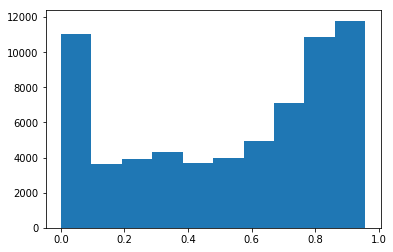

In [31]:
y_model = (logits_model >= .5).astype(np.int).flatten()
plt.hist(logits_model)

## Predict model on all data that was discarded during filtering

In [32]:
large_data_mask = np.ones(data.targets.shape).astype(np.bool)
large_data_mask[data._get_idx('train')] = False
large_data_mask[data._get_idx('val')] = False
large_data_idx = np.where(large_data_mask)[0]
print(f'Large test data consists of {large_data_idx.shape} samples')

Large test data consists of (1615566,) samples


In [83]:
charge = np.array(data.file['TotalCharge']['value'])
pdg_encodings = np.array(data.file['PDGEncoding']['value'])
interaction_type = np.array(data.file['InteractionType']['value'])
y_baseline = (data.delta_loglikelihood >= 2.0).astype(np.uint8)

In [34]:
test_idx = data._get_idx('test')

In [55]:
def binned_ppr(y_pred, y_gnd, charge, bins=50):
    """ Calculates the ppr binned in charges. 
    
    Parameters:
    -----------
    y_pred : ndarray, shape [N]
        Predictions.
    y_gnd : ndarray, shape [N]
        Ground truths.
    charge : ndarray, shape [N]
        Charge values (to be binned.)
    bins : int, optional
        The number of bins.
    
    Returns:
    --------
    ppr : ndarray, shape [bins + 1]
        Positive predicted values for each bin.
    sigma_ppr : ndarray, shape [bins + 1]
        Uncertainty of predicted positive values for each bin.
    bins : ndarray, shape [bins]
        Bin edges.
    """
    log_charge = np.log(charge)
    # Bin all charges
    bin_counts, bins = np.histogram(log_charge, bins=bins, range=(2.0, 5.2))
    # Bin positive predictions
    pos_bin_counts, _ = np.histogram(log_charge[y_pred > 0], bins=bins)
    ppr = pos_bin_counts / bin_counts
    
    # Calculate uncertainty
    sigma_bin_counts = np.sqrt(bin_counts)
    sigma_pos_bin_counts = np.sqrt(pos_bin_counts)
    
    sigma_ppr = np.sqrt(
        ppr**2 * ((sigma_bin_counts / bin_counts)**2 + (sigma_pos_bin_counts / pos_bin_counts)**2))
    return ppr, sigma_ppr, bins

In [141]:
def ppr_plot(y_pred, y_gnd, charges, pdg_encodings, interaction_types, title, plots):
    """ Creates subplots for the ppr by neutrino flavour (and interaction type). """
    pgd_encodings = np.abs(pdg_encodings)
    fig = plt.figure()
    plt.xscale('log')
    
    for plot_label in plots:
        color, pdg_encoding, interaction_type = plots[plot_label]
        if interaction_type is None:
            mask = pdg_encodings == pdg_encoding
        else:
            mask = np.logical_and((pdg_encodings == pdg_encoding), (interaction_types == interaction_type))
                           
        ppr, sigma, bin_edges = binned_ppr(y_pred[mask], y_gnd[mask], charges[mask])
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        plt.errorbar(
            bin_centers,
            ppr,
            yerr = sigma,
            drawstyle = 'steps',
            color=color,
            label=plot_label
        )
    plt.xlabel('log(Integrated Charge) (pe)')
    plt.legend(loc='left', bbox_to_anchor=(1.0, 1.05))
    plt.title(title)

In [202]:
plots = {
    #'nue NC' : ('blue', 12, 2),
    #'nue CC' : ('black', 12, 1),
    'numu CC' : ('green', 14, 1),
    'numu NC' : ('red', 14, 2),
    'nue' : ('blue', 12, None),
    'nutau' : ('purple', 16, None),
    #'nutau NC' : ('green', 16, 2),
    #'nutau CC' : ('brown', 16, 1)

}

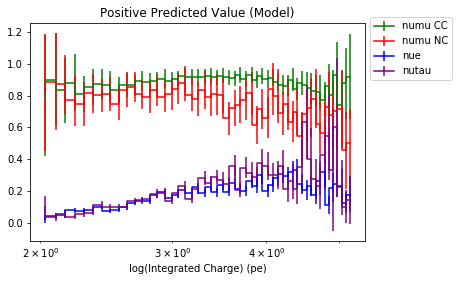

In [203]:
ppr_plot(y_model, data.targets[test_idx], charge[test_idx], pdg_encodings[test_idx], interaction_type[test_idx],
        'Positive Predicted Value (Model)', plots)

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


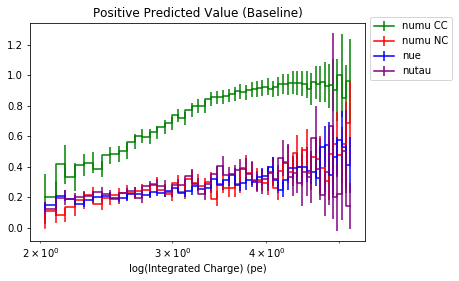

In [206]:
ppr_plot(y_baseline[test_idx], data.targets[test_idx], charge[test_idx], pdg_encodings[test_idx], interaction_type[test_idx],
        'Positive Predicted Value (Baseline)', plots)

## Evaluate the model on the big dataset (that contains everything that was filtered)

In [97]:
# Create a generator for the data
def large_data_generator(batch_size):
    # Loop over the dataset
    while True:
        for idx in range(0, large_data_idx.shape[0], batch_size):
            batch_idxs = large_data_idx[idx : idx + batch_size]
            features, coordinates, masks = data.get_padded_batch(batch_idxs)
            targets = data.targets[batch_idxs]
            yield [features, coordinates, masks], targets

((1615566,), (1615566,))

<ErrorbarContainer object of 3 artists>

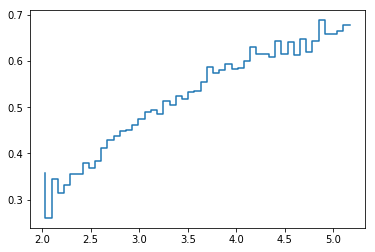

In [213]:
is_numunc = (np.logical_and((np.abs(pdg_encodings) == 14), (interaction_type == 2)))[large_data_idx]
model_preds_numunc = y_model_large_data[is_numunc]
log_charges_numunc = np.log(charge[large_data_idx][is_numunc])

# Bin the charges
bin_counts, bins = np.histogram(log_charges_numunc, bins=50, range=(2.0, 5.2))
bin_counts_positives, _ = np.histogram(log_charges_numunc[model_preds_numunc > 0], bins=bins)
ppr = bin_counts_positives / bin_counts
plt.errorbar(0.5 * (bins[1:] + bins[:-1]), ppr, drawstyle='steps')

In [98]:
logits_model_large_data = model.predict_generator(large_data_generator(batch_size),
                       steps=int(np.ceil(large_data_idx.shape[0] / batch_size)), verbose=1)

25244/25244 [==============================] - 209s 8ms/step


In [105]:
y_model_large_data = (logits_model_large_data >= 0.5).astype(np.int).flatten()

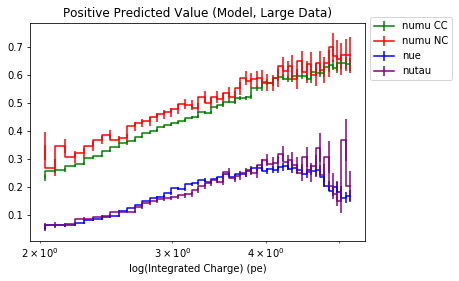

In [207]:
ppr_plot(y_model_large_data, data.targets[large_data_idx], charge[large_data_idx], 
         pdg_encodings[large_data_idx], interaction_type[large_data_idx],
        'Positive Predicted Value (Model, Large Data)', plots)

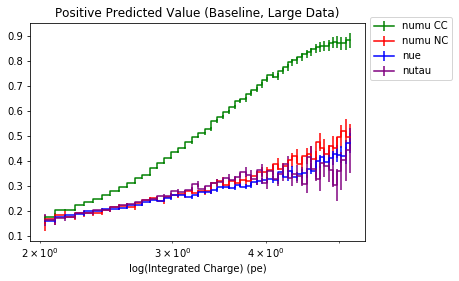

In [209]:
ppr_plot(y_baseline[large_data_idx], data.targets[large_data_idx], charge[large_data_idx], 
         pdg_encodings[large_data_idx], interaction_type[large_data_idx],
        'Positive Predicted Value (Baseline, Large Data)', plots)

In [193]:
acc_model_large_data = (y_model_large_data == data.targets[large_data_idx]).sum() / y_model_large_data.shape[0]
acc_baseline_large_data = (y_baseline[large_data_idx] == data.targets[large_data_idx]).sum() / y_model_large_data.shape[0]
acc_model_large_data, acc_baseline_large_data

(0.5482963865295506, 0.5604611634560271)

# Evaluate the model on the entire dataset
data = HD5Dataset('../data/data_dragon.hd5', seed=42, features=["FirstCharge", "CumulativeCharge", "Time",
            "VertexX", "VertexY", "VertexZ", "RecoX",
"RecoZ", "RecoAzimuth", "RecoZenith"])

In [17]:
#run_idx = 'hd5-875239' Model without cutoff but class balancing
run_idx = 'hd5-860835'

In [18]:
%ls training/{run_idx}

checkpoint/   model_weights_0.h5*  model_weights_3.h5*
config.json*  model_weights_1.h5*  model_weights_4.h5*
history.pkl*  model_weights_2.h5*  model_weights.h5*


In [19]:
with open(f'training/{run_idx}/config.json') as f:
    settings = json.load(f)

In [20]:
data = util.dataset_from_config(settings)

After Track Length filter 1333960 / 2202957 events remain.
After Cascade Energy filter 1167113 / 2202957 events remain.
Reduced dataset to 326328 samples per class (652656 / 2202957)
Created sha1 hash for features and data file c7186ad6f4095a7ceb2168696ef104bbe0381efa
Loaded feature memmap ./memmaps/hd5_features_c7186ad6f4095a7ceb2168696ef104bbe0381efa.
Created distances memmap ./memmaps/hd5_distances_c7186ad6f4095a7ceb2168696ef104bbe0381efa.


In [21]:
model = util.model_from_config(settings)

In [31]:
model.load_weights(f'training/{run_idx}/model_weights.h5')

In [32]:
model.weights

[<tf.Variable 'gaussian_adjacency_matrix_1/sigma:0' shape=(1,) dtype=float32, numpy=array([0.35142273], dtype=float32)>,
 <tf.Variable 'graph_convolution_6/dense_6/kernel:0' shape=(11, 64) dtype=float32, numpy=
 array([[ 0.2239214 ,  0.15596068, -0.13438588, -0.07833476,  0.14623208,
         -0.08545016, -0.02621705, -0.19662471,  0.15228847, -0.20730625,
         -0.09103765, -0.16213174, -0.22246753,  0.04835239, -0.0158903 ,
         -0.13461098, -0.0386467 , -0.25373593,  0.0026829 , -0.26437947,
          0.26145646, -0.00076191,  0.18259798,  0.06007466, -0.17173089,
          0.2913055 , -0.02826076,  0.07315319,  0.06424043,  0.16374806,
          0.20040113,  0.01533565, -0.23864836,  0.17922196, -0.00672318,
         -0.20244783,  0.03283402,  0.23020889,  0.04662801,  0.23188503,
          0.05235031, -0.23137029,  0.15334603,  0.0786277 ,  0.0889988 ,
         -0.27830297,  0.25397697,  0.00536071, -0.2702963 , -0.17338991,
          0.10001887,  0.02417095, -0.28518465, -

In [24]:
data.get_baseline_accuracy()

0.7690834431403794

In [25]:
#test_idx = data._get_idx('test')
# Also append all idx that were kept from the model
#test_idx.shape

In [26]:
data2_config = settings
settings['dataset']['max_charge'] = None
settings['dataset']['balance_classes'] = None
settings['dataset']['min_track_length'] = None
settings['dataset']['max_cascade_energy'] = None
data2 = util.dataset_from_config(data2_config)

Created sha1 hash for features and data file c7186ad6f4095a7ceb2168696ef104bbe0381efa
Loaded feature memmap ./memmaps/hd5_features_c7186ad6f4095a7ceb2168696ef104bbe0381efa.
Created distances memmap ./memmaps/hd5_distances_c7186ad6f4095a7ceb2168696ef104bbe0381efa.


In [27]:
test_idx = data2._get_idx('test')
test_idx.shape

(220295,)

In [33]:
# Evaluate the model on all the data
batch_size = 72
logits_model = model.predict_generator(data2.get_batches(batch_size=batch_size, dataset='test'),
                       steps=int(np.ceil(data2.size(dataset='test') / batch_size)), verbose=1)

3060/3060 [==============================] - 2494s 815ms/step


In [34]:
logits_model

array([[0.25352836],
       [0.11936048],
       [0.14663255],
       ...,
       [0.5826628 ],
       [0.5891738 ],
       [0.51535964]], dtype=float32)

In [35]:
np.unique(logits_model).shape

(218369,)

In [36]:
y_model = (logits_model >= 0.5).astype(np.int)

In [37]:
np.unique(y_model)

array([0, 1])

In [38]:
y_model = y_model.squeeze()

In [39]:
# Get the pe counts (~charge) of the test data
total_charge = data.file['TotalCharge']['value'][test_idx]

In [40]:
y_gnd = data.targets[test_idx]
y_baseline = (data.delta_loglikelihood[test_idx] >= 2.0).astype(np.uint8)

In [41]:
y_model.shape, y_gnd.shape, y_baseline.shape

((220295,), (220295,), (220295,))

In [42]:
total_charge
total_charge.max(), total_charge.min()

(1374.7999986559153, 7.0)

In [43]:
bins = np.logspace(0.8, 3.2)
binned = np.digitize(total_charge, bins)
#np.unique(binned)

In [44]:
def get_metrics(y_pred, y_gnd):
    acc = (y_pred == y_gnd).sum() / len(y_pred)
    tpr = (y_pred[y_gnd == 1] == 1).sum() / ((y_gnd == 1).sum() + 1e-20)
    tnr = (y_pred[y_gnd == 0] == 0).sum() / ((y_gnd == 0).sum() + 1e-20)
    ppr = (y_pred == 1).sum() / y_pred.shape[0]
    return acc, tpr, tnr, ppr

In [45]:
pgd_encoding = np.array(data.file['PDGEncoding']['value'], dtype=np.uint8).astype(np.int8)
pgd_encoding.shape

(2202957,)

In [46]:
(np.abs(pgd_encoding) == 12).sum()

524922

In [47]:
interaction_types = np.array(data.file['InteractionType']['value'], dtype=np.uint8)
interaction_types

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [48]:
np.unique(pgd_encoding, return_counts=True)

(array([-16, -14, -12,  12,  14,  16], dtype=int8),
 array([  46767,  467199,  164192,  360730, 1036437,  127632]))

In [49]:
np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).sum() / interaction_types.shape[0]

0.618337988440083

In [50]:
np.unique(interaction_types)

array([1, 2], dtype=uint8)

In [51]:
data.file.keys()

<KeysViewHDF5 ['CascadeEnergy', 'ChargeFirstPulse', 'ChargeLastPulse', 'ChargeMaxPulse', 'DeltaLLH', 'Distances', 'DistancesOffset', 'IC86_Dunkman_L6_SANTA_DirectCharge', 'IntegratedCharge', 'InteractionType', 'MuonEnergy', 'NumberChannels', 'NumberVertices', 'Offset', 'PDGEncoding', 'RecoAzimuth', 'RecoX', 'RecoY', 'RecoZ', 'RecoZenith', 'TimeFirstPulse', 'TimeLastPulse', 'TimeMaxPulse', 'TimeVariance', 'TotalCharge', 'TrackLength', 'VertexDeltaLLH', 'VertexX', 'VertexY', 'VertexZ']>

In [52]:
y_gnd2 = np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).astype(np.int)

In [53]:
metrics = defaultdict(lambda: defaultdict(list))
for bin_idx, value in enumerate(bins):
    for interaction_type, pgd_code in (('nue', 12), ('numu CC', 14), ('numu NC', 14), ('nutau', 16)):
        # print((np.abs(pgd_encoding) == pgd_code).sum(), pgd_code)
        bin_mask = binned == bin_idx
        enc_mask = np.abs(pgd_encoding[test_idx] == pgd_code)
        if 'numu' in interaction_type:
            it = 1 if 'CC' in interaction_type else 2
            it_mask = interaction_types[test_idx] == it
            #print(it, it_mask.sum())
            idxs = np.where(np.logical_and(bin_mask, np.logical_and(enc_mask, it_mask)))[0]
        else:
            idxs = np.where(np.logical_and(bin_mask, enc_mask))[0]
        # print(idxs.shape)
        for y, t in ((y_model, 'model'), (y_baseline, 'baseline')):
            acc, tpr, tnr, ppr = get_metrics(y[idxs], y_gnd[idxs])
            metrics[interaction_type][t].append({
                'acc' : acc, 'tpr' : tpr, 'ppr' : ppr, 'bin_idx' : bin_idx, 'value' : value, 'num_samples' : idxs.shape[0]
            })

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [54]:
dfs = {
    pgd_code : {
            type_ : pd.DataFrame(data) for type_, data in metrics_code.items()
        } for pgd_code, metrics_code in metrics.items()
    }
for pgd_code, metrics_code in dfs.items():
    for type_, df in metrics_code.items():
        df = df[df['num_samples'] > 100]
        metrics_code[type_] = df

In [55]:
dfs['numu NC']

{'model':          acc  bin_idx  num_samples       ppr  tpr       value
 3   0.940741        3          135  0.059259  0.0    8.849908
 4   0.932432        4          296  0.067568  0.0    9.906457
 5   0.939052        5          443  0.060948  0.0   11.089142
 6   0.950577        6          607  0.049423  0.0   12.413023
 7   0.931889        7          646  0.068111  0.0   13.894955
 8   0.921316        8          699  0.078684  0.0   15.553808
 9   0.930988        9          739  0.069012  0.0   17.410704
 10  0.929577       10          710  0.070423  0.0   19.489286
 11  0.931677       11          644  0.068323  0.0   21.816019
 12  0.903226       12          620  0.096774  0.0   24.420531
 13  0.907873       13          597  0.092127  0.0   27.335983
 14  0.895745       14          470  0.104255  0.0   30.599497
 15  0.883576       15          481  0.116424  0.0   34.252626
 16  0.884444       16          450  0.115556  0.0   38.341886
 17  0.899510       17          408  0.100490 

In [56]:
def plot_metric(metric, metric_name):
    colors = ['blue', 'green', 'red', 'purple']
    fig = plt.figure()
    plt.xscale('log')
    for (pgd_code, df), color in zip(dfs.items(), colors):
        for t in df.keys():
            if t == 'model':
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (model)', color=color)
            else:
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (baseline)', linestyle='dashed', color=color)
    plt.legend(loc='left', bbox_to_anchor=(1.0, 1.05))
    plt.title(metric_name)
    plt.ylim()
    plt.xlabel('log(Integrated Charge) (pe)')


/usr/local/lib/python3.6/dist-packages/matplotlib-3.0.3-py3.6-linux-x86_64.egg/matplotlib/legend.py:497: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


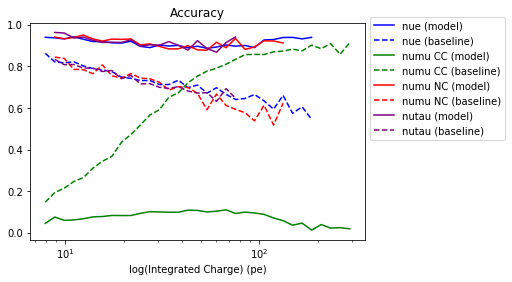

In [57]:
plot_metric('acc', 'Accuracy', )

In [58]:
(y_model == y_gnd).sum() / y_gnd.shape[0]

0.4033091990285753

In [59]:
(y_baseline == y_gnd).sum() / y_gnd.shape[0]

0.6162010032002542

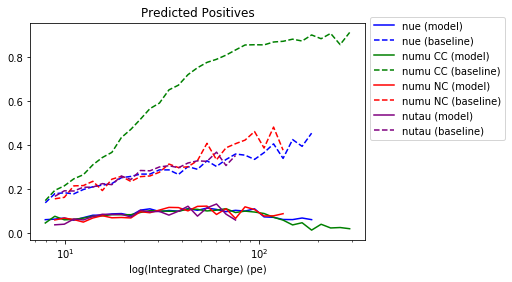

In [60]:
plot_metric('ppr', 'Predicted Positives')

In [49]:
bins_track, bin_counts_track = np.unique(binned[y_gnd > 0], return_counts=True)
bins_non_track, bin_counts_non_track = np.unique(binned[y_gnd <= 0], return_counts=True)
bin_counts_non_track, bin_counts_track


(array([  15,  455, 1550, 3179, 4701, 5964, 6505, 6722, 6417, 5999, 5752,
        5133, 4529, 3866, 3372, 2994, 2620, 2223, 1942, 1652, 1446, 1197,
        1044,  886,  765,  623,  505,  424,  314,  306,  217,  183,  142,
         111,   74,   66,   42,   31,   23,   12,    6,    9,    1,    4,
           7,    1,    1]),
 array([  19,  538, 1836, 4093, 6086, 7511, 8517, 9375, 9176, 8999, 8646,
        8259, 7636, 6971, 6541, 5913, 5341, 4603, 4262, 3880, 3202, 2777,
        2462, 2078, 1739, 1382, 1066,  842,  691,  517,  356,  250,  191,
         152,  119,   69,   58,   37,   23,   20,   13,   11,    4,    1,
           1,    1,    1]))

Text(0.5, 0, 'log(Integrated Charge) (pe)')

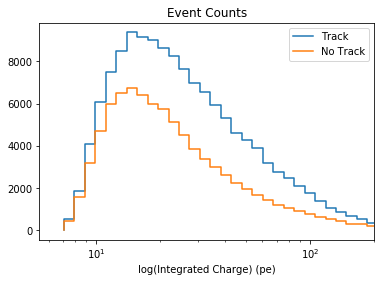

In [50]:
fig = plt.figure()
plt.xscale('log')
plt.step(bins[bins_track], bin_counts_track, label='Track')
plt.step(bins[bins_non_track], bin_counts_non_track, label='No Track')
plt.legend()
plt.xlim(right=2e2)
plt.title('Event Counts')
plt.xlabel('log(Integrated Charge) (pe)')

In [51]:
np.hstack((
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc']),
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc'])
    )
)

array([       nan, 0.45454545, 0.54371585, 0.51602564, 0.51567568,
       0.49527959, 0.51566784, 0.51246347, 0.51382596, 0.50258565,
       0.51834025, 0.52382573, 0.51396848, 0.51608527, 0.53446809,
       0.53135536, 0.53290291, 0.53529572, 0.56768838, 0.58156271,
       0.59902658, 0.59186472, 0.61957091, 0.62044232, 0.59596662,
       0.59243697, 0.53202479, 0.49041096, 0.39739414, 0.36418511,
       0.34816754, 0.27881041, 0.22395833, 0.21830986, 0.17322835,
       0.14130435, 0.09259259, 0.29787234, 0.07407407, 0.125     ,
       0.2       , 0.53846154, 0.375     , 0.        , 1.        ,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.45454545, 0.54371585, 0.51602564, 0.51567568,
       0.49527959, 0.51566784, 0.51246347, 0.51382596, 0.50258565,
       0.51834025, 0.52382573, 0.51396848, 0.51608527, 0.53446809,
       0.53135536, 0.53290291, 0.53529572, 0.56768838, 0.58156271,
       0.59902658, 0.59186472, 0.61957091, 0.62044232, 0.59596

In [52]:
total_charge_sorted = np.sort(total_charge)

In [19]:
# Find different cutoff values to check performance at different maximal energies by selecting the quantiles of the data
cutoffs = []
quantiles = []
for quantile in np.arange(0.00, 1.0, 0.01):
    quantile = 1.0 - quantile
    quantiles.append(quantile)
    cutoffs.append(total_charge_sorted[int(total_charge.shape[0] * quantile) - 1])

In [20]:
y_model.shape, y_gnd.shape

((220295,), (220295,))

In [22]:
metrics = defaultdict(lambda: defaultdict(list))
for cutoff, quantile in zip(cutoffs, quantiles):
    mask = total_charge <= cutoff
    acc_baseline, tpr_baseline, tnr_baseline, ppr_baseline = get_metrics(y_baseline[mask], y_gnd[mask])
    metrics['baseline']['accuracy'].append(acc_baseline)
    metrics['baseline']['tpr'].append(tpr_baseline)
    metrics['baseline']['tnr'].append(tnr_baseline)
    metrics['baseline']['ppr'].append(ppr_baseline)
    acc_model, tpr_model, tnr_model, ppr_model = get_metrics(y_model[mask], y_gnd[mask])
    metrics['model']['accuracy'].append(acc_model)
    metrics['model']['tpr'].append(tpr_model)
    metrics['model']['tnr'].append(tnr_model)
    metrics['model']['ppr'].append(ppr_model)
    metrics['gnd']['ppr'].append((y_gnd[mask] == 1).sum() / y_gnd[mask].shape[0])

Text(0.5, 0.04, 'Integrated Charge (pe)')

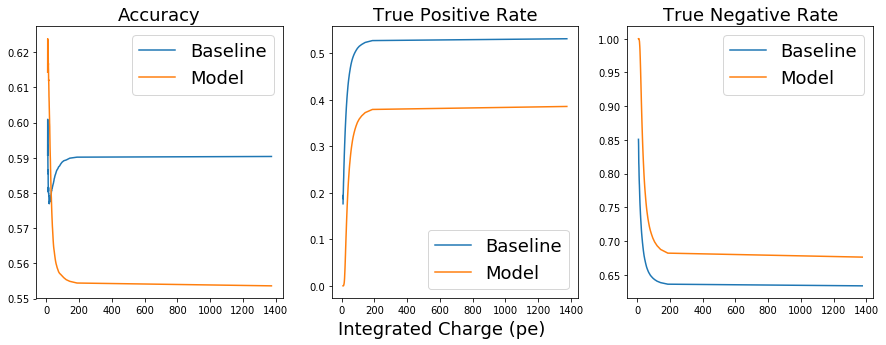

In [23]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax1.plot(cutoffs, metrics['baseline']['accuracy'], label='Baseline')
ax1.plot(cutoffs, metrics['model']['accuracy'], label='Model')
ax1.set_title('Accuracy', fontsize=18)
ax1.legend(fontsize=18)
ax2 = fig.add_subplot(132)
ax2.plot(cutoffs, metrics['baseline']['tpr'], label='Baseline')
ax2.plot(cutoffs, metrics['model']['tpr'], label='Model')
ax2.set_title('True Positive Rate', fontsize=18)
ax2.legend(fontsize=18)
ax3 = fig.add_subplot(133)
ax3.plot(cutoffs, metrics['baseline']['tnr'], label='Baseline')
ax3.plot(cutoffs, metrics['model']['tnr'], label='Model')
ax3.set_title('True Negative Rate', fontsize=18)
ax3.legend(fontsize=18)
fig.text(0.5, 0.04, 'Integrated Charge (pe)', ha='center', va='center', fontsize=18)



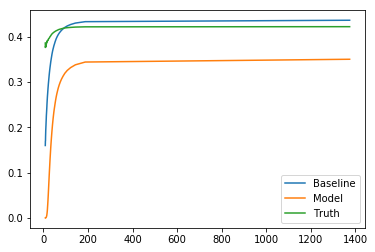

In [24]:
fig = plt.figure()
plt.plot(cutoffs, metrics['baseline']['ppr'], label='Baseline')
plt.plot(cutoffs, metrics['model']['ppr'], label='Model')
plt.plot(cutoffs, metrics['gnd']['ppr'], label='Truth')
plt.legend()


In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
adjacency_matrix_layer_1 (Ad multiple                  1         
_________________________________________________________________
gcnn_block_4 (GCNNBlock)     multiple                  1088      
_________________________________________________________________
gcnn_block_5 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
gcnn_block_6 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
gcnn_block_7 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
dense_2 (Dense)              multiple                  2080      
_________________________________________________________________
batch_normalization_v1_1 (Ba multiple                  128       
__________

In [32]:
model.weights

[<tf.Variable 'adjacency_matrix_layer_1/sigma:0' shape=(1,) dtype=float32, numpy=array([-1.1994079], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense/kernel:0' shape=(16, 64) dtype=float32, numpy=
 array([[-6.7605382e-01, -5.5014306e-01,  1.0545670e+00, ...,
          5.9158012e-02,  4.1892594e-01,  1.1311057e+00],
        [-1.1726910e-01, -3.6698148e-02, -2.5776282e-02, ...,
         -1.6091052e-01, -3.3308864e-03,  1.9296408e-02],
        [-4.5562524e-01, -7.2932534e-02,  3.4593046e-01, ...,
         -2.7987896e-02,  1.9500892e-01,  7.2564250e-01],
        ...,
        [ 2.4853425e-02,  5.2007634e-02,  1.5153764e-04, ...,
         -1.7101361e-01,  9.0077855e-03, -3.0158782e-01],
        [ 1.8562905e-01, -2.1861477e-01, -2.6344028e-01, ...,
         -1.6159213e-01,  5.9850786e-02, -1.6955628e-01],
        [ 1.4021096e-01, -1.9073695e-01, -1.7653483e-01, ...,
          9.7623197e-03, -1.5720429e-02, -1.2895808e-01]], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense/bias:0' shape=(6

In [131]:
np.unique(y_model)

array([0])

# Investigate attributes of the dataset

In [5]:
file = h5py.File('../data/data_dragon2.hd5')

In [13]:
idx = np.arange(file['TimeStdDeviation'].shape[0])
np.random.shuffle(idx)

In [14]:
samples = idx[:100000]

In [18]:
file.keys()

<KeysViewHDF5 ['ChargeFirstPulse', 'ChargeLastPulse', 'DeltaLLH', 'IC86_Dunkman_L6_SANTA_DirectCharge', 'IntegratedCharge', 'InteractionType', 'NumberChannels', 'NumberVertices', 'Offset', 'PDGEncoding', 'RecoAzimuth', 'RecoX', 'RecoY', 'RecoZ', 'RecoZenith', 'TimeFirstPulse', 'TimeLastPulse', 'TimeStdDeviation', 'TotalCharge', 'VertexX', 'VertexY', 'VertexZ', '__I3Index__']>

In [42]:
time_std_samples = file['TimeStdDeviation']['item'][samples]

In [38]:
time_std_samples = time_std_samples[time_std_samples < 1e-5]

In [43]:
time_std_samples

array([1.2055448e-03, 1.1102230e-16, 0.0000000e+00, ..., 0.0000000e+00,
       0.0000000e+00, 2.8057413e-03], dtype=float32)

(array([76768.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  4604.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,   264.]),
 array([0.00000000e+00, 2.22044600e-18, 4.44089200e-18, 6.66133800e-18,
        8.88178400e-18

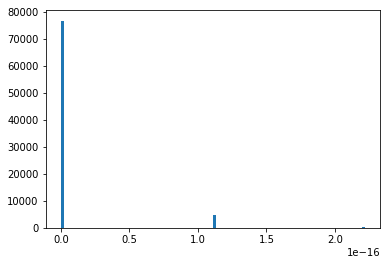

In [39]:
plt.hist(time_std_samples, bins=100)

In [40]:
charge_samples = file['ChargeFirstPulse']['item'][samples]

In [27]:
charge_samples = charge_samples[charge_samples <= 5]

(array([3072., 3387., 3761., 4108., 4557., 5143., 5673., 5869., 6233.,
           0., 6162., 6139., 5778., 5318., 4768., 4331., 3793., 3172.,
           0., 2688., 2301., 1654., 1348., 1078.,  891.,  731.,  589.,
           0.,  528.,  435.,  373.,  360.,  345.,  307.,  296.,  278.,
           0.,  259.,  222.,  214.,  202.,  214.,  174.,  185.,  134.,
           0.,  137.,  121.,  134.,   90.,  136.,   94.,   87.,   85.,
           0.,   75.,   86.,   84.,   47.,   75.,   48.,   55.,   42.,
           0.,   39.,   36.,   49.,   49.,   39.,   48.,   36.,   37.,
           0.,   32.,   27.,   32.,   32.,   41.,   35.,   43.,   27.,
           0.,   28.,   21.,   21.,   24.,   27.,   20.,   18.,   13.,
           0.,   24.,   15.,   21.,   18.,   13.,   21.,   15.,   14.,
          11.]),
 array([0.525     , 0.56949997, 0.61399996, 0.65849996, 0.70299995,
        0.74749994, 0.792     , 0.8365    , 0.881     , 0.9255    ,
        0.96999997, 1.0145    , 1.059     , 1.1035    , 1.148     

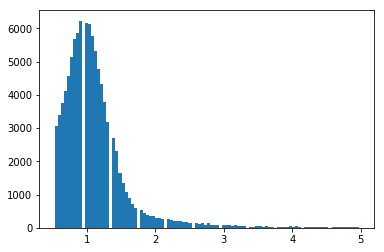

In [29]:
plt.hist(charge_samples, bins=100)

In [48]:
time_samples = file['TimeFirstPulse']['item'][samples]

In [51]:
time_samples_filtered = time_samples[time_samples > -0.002]

In [55]:
time_samples_filtered.std()

0.00030537526